In [25]:
# !pip install pyspark

In [26]:
import pyspark
import pyspark.pandas as ps
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark import SparkContext
from pyspark.ml.feature import StandardScaler

%matplotlib inline

## Read CSV using SQL Spark

In [27]:
spark = SparkSession.builder \
    .master("local") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [28]:
pyspark

<module 'pyspark' from '/usr/local/lib/python3.7/dist-packages/pyspark/__init__.py'>

In [29]:
ps_df = spark.read.options(header='true',inferschema='true').csv('/content/drive/MyDrive/data/CC GENERAL.csv')

In [30]:
ps_df.show()

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+
| C10001|  40.900749|         0.818182|     95.4|             0.0|                  95.4|  

In [31]:
ps_df = ps_df.toPandas()

In [32]:
ps_df .head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [33]:
ps_df.shape

(8950, 18)

In [34]:
#drop customer id
ps_df = ps_df.drop('CUST_ID',axis=1) 

In [35]:
ps_df.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [36]:
#drop null values
ps_df = ps_df.dropna(axis=0).reset_index(drop=True)

In [37]:
ps_df.shape

(8636, 17)

{'boxes': [<matplotlib.lines.Line2D at 0x7f4166a950d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f41688dce90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f41688dbed0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f41688db990>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f41688dc410>,
  <matplotlib.lines.Line2D at 0x7f41688dc950>]}

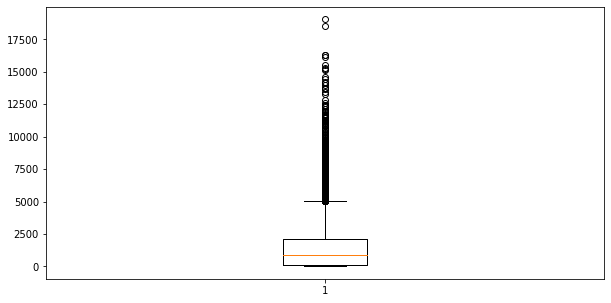

In [38]:
plt.figure(figsize=(10,5))

plt.boxplot(ps_df['BALANCE'])

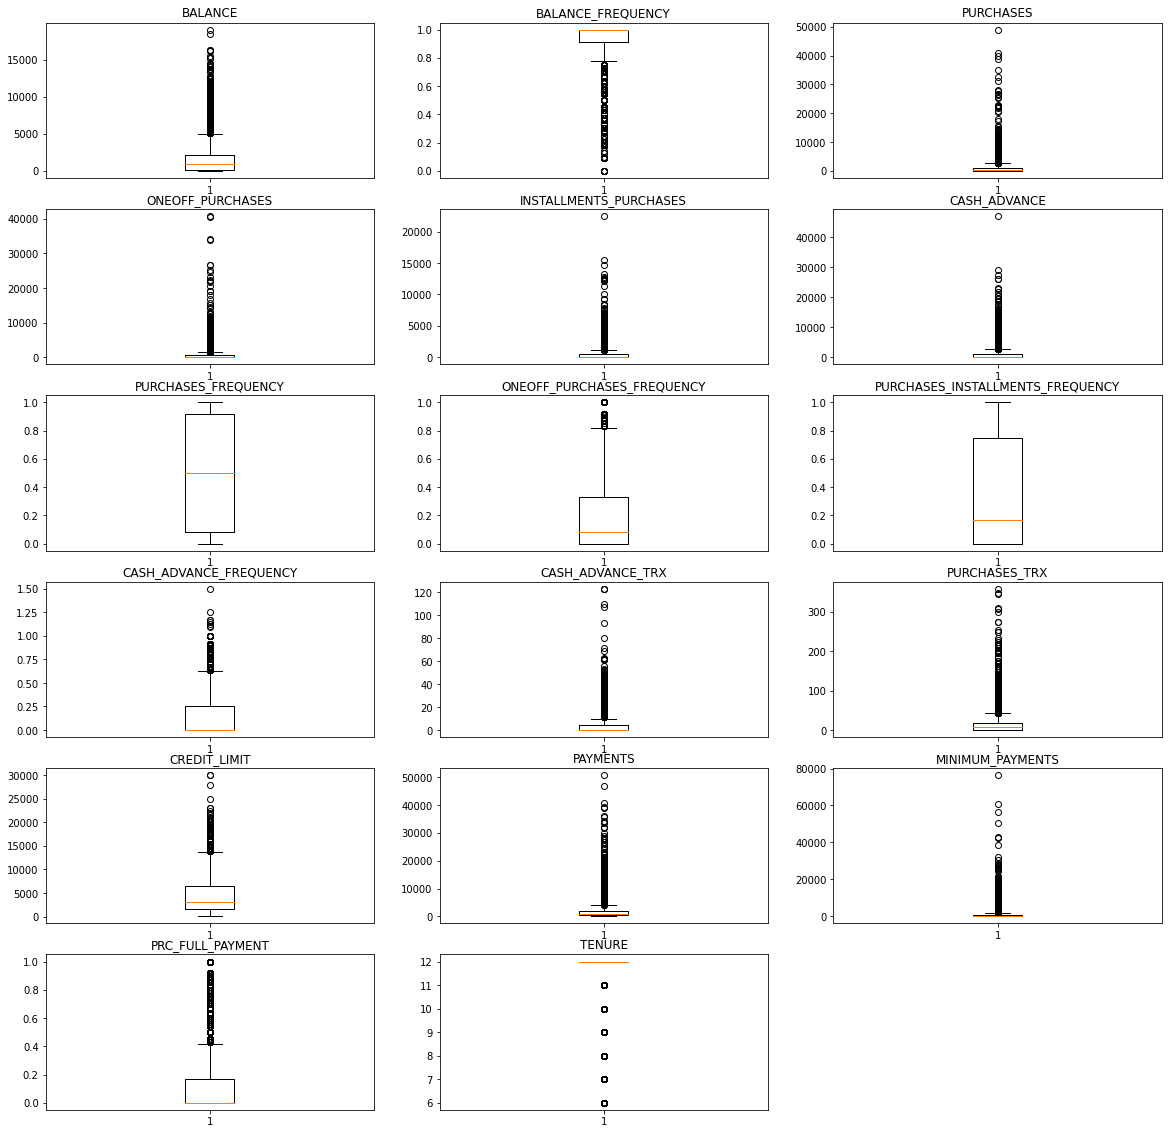

In [39]:
plt.figure(figsize=(20,20))

#get column (features)
features = ps_df.columns

for i in range(len(features)):
  plt.subplot(6,3,i+1)
  plt.boxplot(ps_df[features[i]])
  plt.title(features[i])


In [40]:
features = ps_df.columns
features

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [41]:
def detect_outliers(features):
  q1,q3 = features.quantile([0.25,0.75])
  interquantile_range = q3 - q1
  lower_bound = q1 - (1.5 * interquantile_range)
  upper_bound = q3 + (1.5 * interquantile_range)

  return lower_bound,upper_bound

In [42]:
features = ps_df.columns

for feature in features:
  # get lower bound and upper bound
  lb, ub = detect_outliers(ps_df[feature])
  # drop outliers which are less than the lower bound
  ps_df[feature] = np.where(ps_df[feature] < lb, lb, ps_df[feature])
  # drop outliers which are greater than the upper bound
  ps_df[feature] = np.where(ps_df[feature] > ub, ub, ps_df[feature])

In [43]:
ps_df

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40000,0.000000,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0
1,3202.467416,0.909091,0.00,0.00,0.00000,2830.963725,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0
2,2495.148862,1.000000,773.17,773.17,0.00000,0.000000,1.000000,0.833333,0.000000,0.000000,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0
3,817.714335,1.000000,16.00,16.00,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0
4,1809.828751,1.000000,1333.28,0.00,1210.36875,0.000000,0.666667,0.000000,0.583333,0.000000,0.0,8.0,1800.0,1400.057770,1809.995839,0.000000,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8631,5.871712,0.772728,20.90,20.90,0.00000,0.000000,0.166667,0.166667,0.000000,0.000000,0.0,1.0,500.0,58.644883,43.473717,0.000000,12.0
8632,28.493517,1.000000,291.12,0.00,291.12000,0.000000,1.000000,0.000000,0.833333,0.000000,0.0,6.0,1000.0,325.594462,48.886365,0.416668,12.0
8633,23.398673,0.833333,144.40,0.00,144.40000,0.000000,0.833333,0.000000,0.666667,0.000000,0.0,5.0,1000.0,81.270775,82.418369,0.250000,12.0
8634,13.457564,0.833333,0.00,0.00,0.00000,36.558778,0.000000,0.000000,0.000000,0.166667,2.0,0.0,500.0,52.549959,55.755628,0.250000,12.0


In [44]:
ps_df.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

{'boxes': [<matplotlib.lines.Line2D at 0x7f41644b3fd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f41644bef90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f41644c5f50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f41644c5a50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f41644be550>,
  <matplotlib.lines.Line2D at 0x7f41644bea50>]}

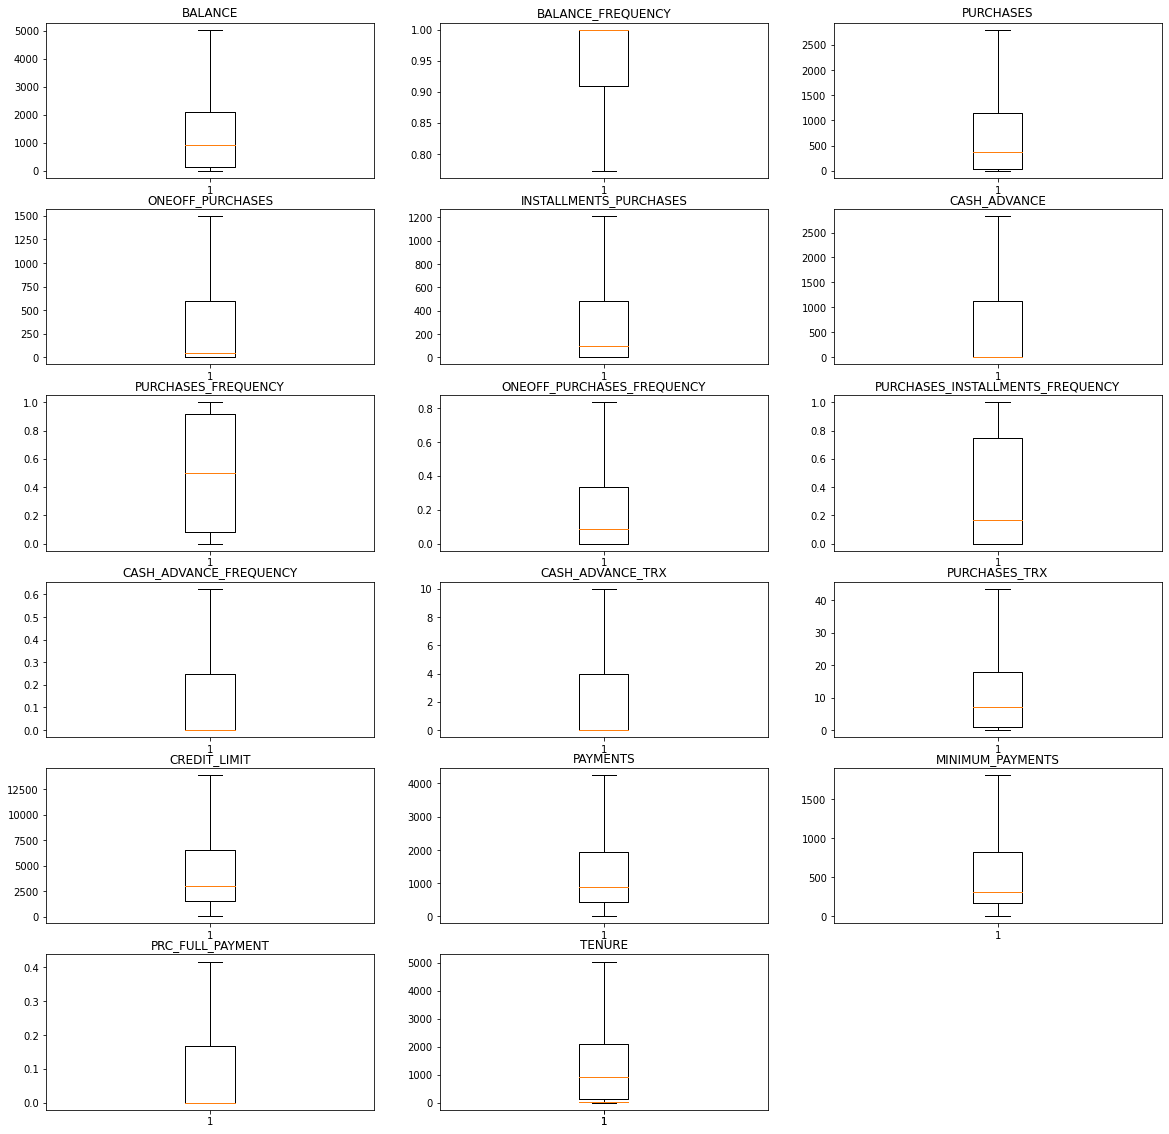

In [45]:
plt.figure(figsize=(20,20))

#get column (features)
features = ps_df.columns

for i in range(len(features)):
  plt.subplot(6,3,i+1)
  plt.boxplot(ps_df[features[i]])
  plt.title(features[i])

plt.boxplot(ps_df['BALANCE'])

Try KMeans

In [46]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

# from pandas dataframe to sql dataframe
pyspark_df = sqlContext.createDataFrame(ps_df)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [47]:
pyspark_df.show()

+------------------+-----------------+----------+----------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------------+----------------+----------------+------+
|           BALANCE|BALANCE_FREQUENCY| PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|      CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|      PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+------------------+-----------------+----------+----------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------------+----------------+----------------+------+
|         40.900749|         0.818182|      95.4|             0.

In [48]:
vecAssembler = VectorAssembler(inputCols=pyspark_df.columns, outputCol="features")
vecAssembler.setInputCols(pyspark_df.columns)
vec_assembler_features = vecAssembler.transform(pyspark_df)

In [49]:
vec_assembler_features.show()

+------------------+-----------------+----------+----------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------------+----------------+----------------+------+--------------------+
|           BALANCE|BALANCE_FREQUENCY| PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|      CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|      PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|
+------------------+-----------------+----------+----------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------------+----------------+----------------+------+--------------------+
|

In [50]:
standardScaler = StandardScaler()
standardScaler.setInputCol("features")
standardScaler.setOutputCol("scaled")
model = standardScaler.fit(vec_assembler_features)
scaled_features = model.transform(vec_assembler_features)

In [51]:
scaled_features.show()

+------------------+-----------------+----------+----------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------------+----------------+----------------+------+--------------------+--------------------+
|           BALANCE|BALANCE_FREQUENCY| PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|      CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|      PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|              scaled|
+------------------+-----------------+----------+----------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------------+----------------+-----

In [52]:
scaled_features.collect()[0].scaled

DenseVector([0.0262, 9.0228, 0.1057, 0.0, 0.2341, 0.0, 0.4153, 0.0, 0.2093, 0.0, 0.0, 0.1469, 0.294, 0.1571, 0.249, 0.0, 0.0])

In [53]:
# try PCA
pca = PCA(k=2, inputCol='scaled')

In [54]:
pca.setOutputCol("pca_features")

PCA_9d9c5fcc7c07

In [55]:
model = pca.fit(scaled_features)

In [56]:
model.setOutputCol("output")

PCAModel: uid=PCA_9d9c5fcc7c07, k=2

In [57]:
transformed = model.transform(scaled_features)

In [58]:
transformed.collect()[0].output

DenseVector([1.0498, 2.1349])

In [59]:
transformed.show()

+------------------+-----------------+----------+----------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------------+----------------+----------------+------+--------------------+--------------------+--------------------+
|           BALANCE|BALANCE_FREQUENCY| PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|      CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|      PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|              scaled|              output|
+------------------+-----------------+----------+----------------+----------------------+------------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+--------

In [60]:
transformed_df = transformed.toPandas()

In [61]:
transformed_df['output']

0         [1.049798354897148, 2.1348764471819073]
1       [0.36923411779708404, 6.8112018364939795]
2        [3.8205636328295896, 4.9485501616443575]
3         [1.0241807313798006, 2.973674211609384]
4         [3.6234925826487934, 4.847995855619599]
                          ...                    
8631     [0.9753727308170765, 1.9400853991403415]
8632      [3.360072976048417, 2.0991906020228224]
8633       [2.53684473321647, 1.8232865708705384]
8634     [0.5866472650409751, 2.2554236835696524]
8635     [3.1326604490016843, 3.8830493233410373]
Name: output, Length: 8636, dtype: object

In [62]:
# 1. throw every column to KMeans first, and visualize the output of KMeans
# 2. throw every column to PCA first, and then throw output from PCA to KMeans and visualize the output of PCA-KMeans
# 3. compare both of them

In [63]:
# Calculate cost and plot
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('output')
    model = kmeans.fit(transformed)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:], columns=['cost'])
new_col = [2,3,4,5,6,7,8,9]
df_cost.insert(0, 'cluster', new_col)

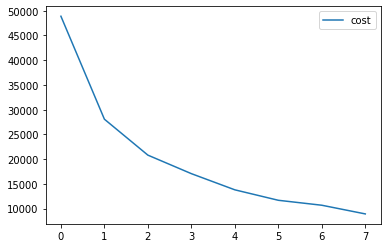

In [64]:
df_cost.plot(kind='line', y='cost')

In [65]:
kmeans = KMeans(k=3, featuresCol='output')

In [66]:
model = kmeans.fit(transformed)
model.setPredictionCol("newPrediction")

KMeansModel: uid=KMeans_896410c68ed5, k=3, distanceMeasure=euclidean, numFeatures=2

In [67]:
centers = model.clusterCenters()

In [68]:
centers

[array([2.29914743, 3.20090144]),
 array([5.9513078 , 5.68489568]),
 array([0.49225081, 6.62352579])]

In [69]:
transformed_kmeans_df = model.transform(transformed).select("output", "newPrediction")

In [70]:
transformed_kmeans_df.show()

+--------------------+-------------+
|              output|newPrediction|
+--------------------+-------------+
|[1.04979835489714...|            0|
|[0.36923411779708...|            2|
|[3.82056363282958...|            1|
|[1.02418073137980...|            0|
|[3.62349258264879...|            0|
|[8.46517283187978...|            1|
|[3.39354748128701...|            0|
|[2.61884474527892...|            0|
|[2.71515280380832...|            0|
|[3.93067594831500...|            0|
|[2.84720617982596...|            0|
|[6.33316178182572...|            1|
|[5.53371918647175...|            1|
|[0.54385866117659...|            2|
|[2.90317131780866...|            2|
|[-0.2810240082981...|            2|
|[2.45578498189979...|            0|
|[3.23347320680729...|            0|
|[3.28618523208903...|            0|
|[2.22304561647150...|            0|
+--------------------+-------------+
only showing top 20 rows



In [71]:
transformed_kmeans_df = transformed_kmeans_df.toPandas()

In [72]:
transformed_kmeans_df

,output,newPrediction
0,"[1.049798354897148, 2.1348764471819073]",0
1,"[0.36923411779708404, 6.8112018364939795]",2
2,"[3.8205636328295896, 4.9485501616443575]",1
3,"[1.0241807313798006, 2.973674211609384]",0
4,"[3.6234925826487934, 4.847995855619599]",0
...,...,...
8631,"[0.9753727308170765, 1.9400853991403415]",0
8632,"[3.360072976048417, 2.0991906020228224]",0
8633,"[2.53684473321647, 1.8232865708705384]",0
8634,"[0.5866472650409751, 2.2554236835696524]",0


In [73]:
x, y = [], []

for value in transformed_kmeans_df['output'].values:
  x.append(value[0])
  y.append(value[1])

In [74]:
transformed_kmeans_df['x'] = x
transformed_kmeans_df['y'] = y

In [75]:
transformed_kmeans_df = transformed_kmeans_df.drop('output', axis=1)

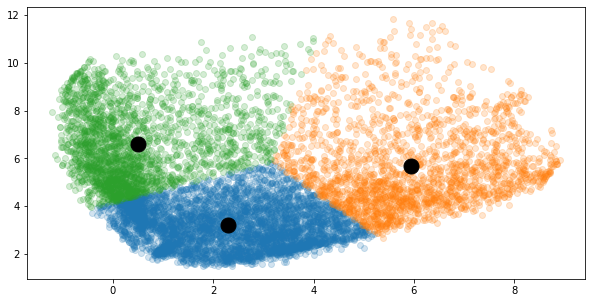

In [80]:
plt.figure(figsize=(10, 5))

for i in np.unique(transformed_kmeans_df['newPrediction'].values):
  sub_df = transformed_kmeans_df[transformed_kmeans_df['newPrediction'] == i]
  plt.scatter(sub_df['x'], sub_df['y'], alpha=0.2)
  plt.plot(centers[i][0], centers[i][1], color='black', marker='o', markersize=15)
  del sub_df